# Sentiment Analysis with an CNN

In this notebook, I implement a convolutional neural network (CNN) that will be trained using the traning set of the IMDB reviews database and it will be tested on its corresponding testing set. The databases has been downloaded from:
__[http://ai.stanford.edu/~amaas/data/sentiment/](http://ai.stanford.edu/~amaas/data/sentiment/)__

Words will be turned into numerical vector by the means of an embedding layer. The word vector sequences will be first "analyzed" using one (words), three (trigrams), five (pentagrams) and seven-word (heptagrams) wide filters. 

The model is implemented in python using pyTorch.



## Imports
Let's import the modules we will use


In [1]:
import os
import pickle
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from string import punctuation
from collections import Counter

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('seaborn')

In [3]:
 #print(plt.style.available)

## Using GPUs?
Let's check if a GPU is available and select the device use for optimization

In [4]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


---
## Load in, tokenize and visualize the data

The download data is already divied into train and test data. Each folder is further divided into positive (7-10/10 stars reviews) and negative reviews (1-4/10 stars reviews).

In [5]:
#training positive reviews directory
train_pos_dir = r'aclImdb/train/pos/'
#negative positive reviews directory
train_neg_dir = r'aclImdb/train/neg/'

#List of files with training positive review
train_pos_rev_files = os.listdir(train_pos_dir)
#List of files with training negative review
train_neg_rev_files = os.listdir(train_neg_dir)
print('TRAIN SET')
print('Number of positive reviews:',len(train_pos_rev_files),'Number of negative reviews:',len(train_neg_rev_files))

TRAIN SET
Number of positive reviews: 12500 Number of negative reviews: 12500


Let's keep track of the number of stars (1-10) awarded to each positive and negative review in the train set

In [6]:
full_train_stars = []
for file in train_pos_rev_files:
    full_train_stars.append(int(file.split('_')[1].split('.')[0]))
for file in train_neg_rev_files:
    full_train_stars.append(int(file.split('_')[1].split('.')[0]))    
full_train_stars = np.array(full_train_stars)

In [7]:
#training positive reviews directory
test_pos_dir = r'aclImdb/test/pos/'
#negative positive reviews directory
test_neg_dir = r'aclImdb/test/neg/'

#List of files with training positive review
test_pos_rev_files = os.listdir(test_pos_dir)
#List of files with training negative review
test_neg_rev_files = os.listdir(test_neg_dir)
print('TEST SET')
print('Number of positive reviews:',len(test_pos_rev_files),'Number of negative reviews:',len(test_neg_rev_files))

TEST SET
Number of positive reviews: 12500 Number of negative reviews: 12500


Let's keep track of the number of stars (1-10) awarded to each positive and negative review in the test set

In [8]:
test_stars = []
for file in test_pos_rev_files:
    test_stars.append(int(file.split('_')[1].split('.')[0]))
for file in test_neg_rev_files:
    test_stars.append(int(file.split('_')[1].split('.')[0]))    
test_stars = np.array(test_stars)

Note that 5- and 6-star reviews are not included in the train or test set

In [9]:
print(np.unique(full_train_stars))
print(np.unique(test_stars))

[ 1  2  3  4  7  8  9 10]
[ 1  2  3  4  7  8  9 10]


#### Target Matrices
Let's create numpy arrays that hold the train and test labels. 1 stands for positive and 0 for negative. Since we will stack first the positive reviews and the the negative ones, the first 12500 elements are ones and the next 12500 are zeros.

In [10]:
#Train target array
full_train_target = np.zeros(len(train_neg_rev_files)+len(train_neg_rev_files), dtype=int)
full_train_target[:len(train_neg_rev_files)] = 1
#Test target array
test_target = np.zeros(len(test_neg_rev_files)+len(test_neg_rev_files), dtype=int)
test_target[:len(test_neg_rev_files)] = 1

In [11]:
print(full_train_target.shape, test_target.shape)
print(full_train_target.mean(), test_target.mean())

(25000,) (25000,)
0.5 0.5


#### Remove Contractions
The following function expands common english contractions. There is obviously  plenty of room for improvement. Some 
actions are 100% justified (can't and cannot into can not), while others are rather arbitrary ('s into is)

In [12]:
def remove_contractions(text):
    # Turn ain't into am not (it could be many other oprions such us is not,...)
    text = text.replace("ain't", "am not")
    #Turn can't and annot into can not
    text = text.replace("can't", "can not").replace("cannot", "can not")
    #Turn shan't into shall not
    text = text.replace("shan't", "shall not")
    #Turn won't into will not
    text = text.replace("won't", "will not")
    #Turn y'all into you all
    text = text.replace("y'all", "you all")
    #Turn n't into not
    text = text.replace("n't", " not")
    #Turn 'd into would (it might be had too)
    text = text.replace("'d", " would")
    #Turn 'll into will
    text = text.replace("'ll", " will")
    #Turn 're into are
    text = text.replace("'re", " are")
    #Turn 'm into am
    text = text.replace("'m", " am")
    #Turn 's into is (it could also be has or the posssesive)
    text = text.replace("'s", " is")
    return text

#### Reviews as List of Words
For each review we convert every character to lower case, remove english contructions, then remove punctuation and finally split it into words

Let's start with the train set

In [13]:
full_train_reviews=[]
#Read and tokenize positive reviews
for file_name in train_pos_rev_files:
    with open(train_pos_dir+file_name, 'r',encoding="utf8") as f:
        review = f.read().lower()
        #remove some contractions
        review = remove_contractions(review)
        #remove punctuation
        review = ''.join([c for c in review if c not in punctuation])
        #split in words
        review = review.split()  
    full_train_reviews.append(review)

#Read and tokenize negative reviews
for file_name in train_neg_rev_files:
    with open(train_neg_dir+file_name, 'r',encoding="utf8") as f:
        review = f.read().lower()
        #remove some contractions
        review = remove_contractions(review)
        #remove punctuation
        review = ''.join([c for c in review if c not in punctuation])
        #split in words
        review = review.split()  
    full_train_reviews.append(review)

In [14]:
print(len(full_train_reviews))
print(full_train_reviews[0])

25000
['br', 'br', 'if', 'you', 'like', 'rap', 'or', 'hiphop', 'watch', 'this', 'movie', 'although', 'it', 'is', 'funny', 'if', 'you', 'do', 'not', 'get', 'the', 'references', 'as', 'a', 'straight', 'comedybr', 'br', 'have', 'not', 'seen', 'much', 'of', 'the', 'much', 'hyped', 'cb4', 'but', 'what', 'i', 'did', 'see', 'did', 'not', 'have', 'the', 'heart', 'that', 'this', 'little', 'stormer', 'hasbr', 'br', 'have', 'not', 'heard', 'from', 'the', 'people', 'involved', 'since', 'which', 'is', 'a', 'surprise', 'the', 'film', 'is', 'very', 'similar', 'to', 'spinal', 'tap', 'which', 'is', 'no', 'bad', 'thing', 'and', 'i', 'think', 'a', 'lot', 'of', 'the', 'dialogue', 'while', 'priceless', 'in', 'tap', 'is', 'funnier', 'here', 'probably', 'because', 'i', 'am', 'more', 'into', 'rap', 'than', 'rock', 'theses', 'days', 'so', 'my', 'own', 'judgment', 'does', 'cloud', 'that', 'pointbr', 'br', 'the', 'rap', 'songs', 'are', 'funny', 'as', 'hell', 'and', 'it', 'is', 'basically', 'spot', 'the', 'refere

Now the test set

In [15]:
test_reviews=[]
#Read and tokenize positive reviews
for file_name in test_pos_rev_files:
    with open(test_pos_dir+file_name, 'r',encoding="utf8") as f:
        review = f.read().lower()
        #remove some contractions
        review = remove_contractions(review)
        #remove punctuation
        review = ''.join([c for c in review if c not in punctuation])
        #split in words
        review = review.split()  
    test_reviews.append(review)

#Read and tokenize negative reviews
for file_name in test_neg_rev_files:
    with open(test_neg_dir+file_name, 'r',encoding="utf8") as f:
        review = f.read().lower()
        #remove some contractions
        review = remove_contractions(review)
        #remove punctuation
        review = ''.join([c for c in review if c not in punctuation])
        #split in words
        review = review.split()  
    test_reviews.append(review)

In [16]:
print(len(test_reviews))
print(test_reviews[0])

25000
['the', 'dresser', 'is', 'perhaps', 'the', 'most', 'refined', 'of', 'backstage', 'films', 'the', 'film', 'is', 'brimming', 'with', 'wit', 'and', 'spirit', 'for', 'the', 'most', 'part', 'provided', 'by', 'the', 'energetic', 'character', 'of', 'norman', 'tom', 'courtenay', 'although', 'his', 'character', 'is', 'clearly', 'gay', 'and', 'certainly', 'has', 'an', 'attraction', 'for', 'the', 'lead', 'performer', 'albert', 'finney', 'that', 'he', 'assists', 'the', 'film', 'never', 'dwells', 'on', 'it', 'or', 'makes', 'it', 'more', 'than', 'it', 'isbr', 'br', 'the', 'gritty', 'style', 'of', 'peter', 'yates', 'that', 'worked', 'so', 'well', 'in', 'bullitt', 'is', 'again', 'on', 'display', 'and', 'gives', 'the', 'film', 'a', 'sense', 'of', 'realism', 'and', 'coherence', 'this', 'is', 'much', 'appreciated', 'in', 'a', 'story', 'that', 'could', 'so', 'easily', 'have', 'become', 'tedious', 'in', 'the', 'end', 'the', 'dresser', 'will', 'bore', 'many', 'people', 'silly', 'but', 'it', 'will', 't

## Training and Validation Sets

We will divide our full train set into a train set and a validation set that will help us to control how our model generalize.
The validation set will be just 10% of the original train set. We envision that depending of the star calification of the review it would be more or less complicated to infer its sentiment. Then, we will keep the same distribution of stars within the train and validation sets

In [17]:
#90% will remain as training data
train_size = 0.9; test_size = 1-train_size
(train_reviews, valid_reviews, train_y, valid_y, 
 train_stars, valid_stars) = train_test_split(full_train_reviews, full_train_target, full_train_stars,
                                              random_state=123, shuffle=True,
                                              train_size=train_size, test_size=test_size,stratify=full_train_stars)

In [18]:
#Print out the shapes of your resultant feature data
print(len(train_reviews), train_y.shape, train_stars.shape)
print(len(valid_reviews), valid_y.shape, valid_stars.shape)
print(train_y.mean(), valid_y.mean())

22500 (22500,) (22500,)
2500 (2500,) (2500,)
0.5 0.5


In [19]:
#To keep it simple let's create a test_y variable
test_y = test_target

## Fixing the size of the reviews
It is important to xhoose now the word size of our review before we build our vocabulary. That will prevent us from including
words that may appear frequently in our reviews if we keep all the words but not more than five times if we keep, 
let's say, the first 50 words only. Of course, the larger the sequence considered the less important this would be.


In [20]:
######## Sequence length #########
seq_length = 350

## Data pre-processing

Let's get our data into the proper form to feed into the network. Since we're using embedding layers, we'll need to encode each word with an integer.

Let's put our the words of our training set into a list

In [21]:
all_words = []
for review in train_reviews:
    all_words.extend(review[:seq_length]) #Only words that are going to be used in the model
print(len(all_words))

4560680


In [22]:
all_words[:30]

['this',
 'is',
 'the',
 'worst',
 'movie',
 'i',
 'ever',
 'paid',
 'to',
 'see',
 'and',
 'with',
 'the',
 'exception',
 'of',
 'they',
 'saved',
 'hitler',
 'is',
 'brain',
 'the',
 'worst',
 'movie',
 'i',
 'have',
 'ever',
 'seen',
 'period',
 'when',
 'this']

### Encoding the words

The embedding lookup requires that we pass in integers to our network. The easiest way to do this is to create dictionaries that map the words in the vocabulary to integers. Then we can convert each of our reviews into integers so they can be passed into the network.Also we are going to keep the value zero to represent the padding and the value 1 to represent every word
that appears least than five times in our train set

In [23]:
from collections import Counter

## Build a dictionary that maps words to integers
counts = Counter(all_words)
# Let's reorder counts by word fewuency so the least common words are at the end
words = sorted(counts, key=counts.get, reverse=True)

#Remove words that appear less than 5 times
i = 0
for val in counts.values():
    if val<5:
        i+=1
#Let's keep the most common words and add '<pad>' and '<unk>'        
words = ['<pad>','<unk>'] + words[:-i]
#Create a dictionary, value 1 will indicate unseen or seen less than 5 times word (<unk>). Zero is for padding <pad>
word_to_int = {word: i for i,word in enumerate(words)}

# Let's tokenize the reviews into integers
# train set
train_reviews_int = []
for review in train_reviews:
    train_reviews_int.append([word_to_int.get(word,1) for word in review])
# validation set
valid_reviews_int = []
for review in valid_reviews:
    valid_reviews_int.append([word_to_int.get(word,1) for word in review])
# test set
test_reviews_int = []
for review in test_reviews:
    test_reviews_int.append([word_to_int.get(word,1) for word in review])


In [24]:
print(f'Remove: {i} \t Kept: {len(words)}')

Remove: 75416 	 Kept: 27116


**Test your code**

As a text that you've implemented the dictionary correctly, print out the number of unique words in your vocabulary and the contents of the first, tokenized review.

In [25]:
# stats about vocabulary
print('Unique words: ', len((word_to_int)))  
print()

# print tokens in first review
print('Tokenized review: \n', train_reviews_int[0])
print(len(train_reviews_int))

Unique words:  27116

Tokenized review: 
 [11, 3, 2, 222, 17, 10, 121, 1413, 7, 69, 5, 18, 2, 1309, 6, 33, 1847, 1848, 3, 1261, 2, 222, 17, 10, 25, 121, 106, 809, 54, 11, 17, 349, 47, 10, 15, 4, 185, 310, 6, 3982, 5, 13131, 5, 1571, 15, 12099, 48, 10, 183, 51, 28, 2, 1347, 17, 12, 82, 28, 1076, 220, 8, 72, 13, 25, 2, 11660, 2, 228, 17867, 264, 206, 845, 18, 14, 14, 2, 883, 206, 25, 183, 74, 58, 1313, 9, 49, 22152, 49, 20381, 569, 49, 708, 383, 5, 1310, 74, 25, 4, 11661, 510, 15853, 1293, 199, 2, 474, 118, 5328, 22, 156, 55, 75, 708, 16809, 186, 13132, 23, 267, 3, 97, 4, 845, 18, 365, 22152, 2, 782, 19014, 186, 129, 1231, 2, 681, 232, 5, 40, 1398, 15, 42, 1005, 80, 308, 363, 453, 2, 22153, 1144, 9966, 15, 4536, 453, 19, 1, 868, 2, 987, 6490, 5329, 15, 1906, 453, 738, 5112, 1, 2, 726, 8939, 1297, 181, 1980, 1340, 12100, 39, 3, 60, 1454, 18, 4, 726, 1154, 15, 78, 24, 81, 57, 5551, 14, 2, 65, 150, 5329, 535, 7976, 1262, 67, 4111, 19, 4, 213, 843, 11, 793, 24, 81, 1907, 1617, 6, 706, 9, 11,

### Length of the Reviews 

We have already set for a value of 500 words but it is convinient to check some statistic about the review lenght (mean,
median, std). We may even decide to run the whole notebook with a different sequence lenght.

In [26]:
review_lens = np.array([len(x) for x in train_reviews_int])

print(f"Minimum review length: {review_lens.min()}")
print(f"Maximum review length: {review_lens.max()}")
print(f'Mean and Median review length: {review_lens.mean()}\t{np.median(review_lens)}')
print(f'Std review length: {review_lens.std()}')

Minimum review length: 10
Maximum review length: 2501
Mean and Median review length: 237.54746666666668	177.0
Std review length: 175.75619227979803


---
## Padding sequences

To deal with both short and very long reviews, we'll pad or truncate all our reviews to a specific length. For reviews shorter than some `seq_length`, we'll pad with 0s. For reviews longer than `seq_length`, we can truncate them to the first `seq_length` words. We will work with a sewuence lenght of 500.

In [27]:
def pad_features(reviews_ints, seq_length, alignment='right'):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    features=np.zeros((len(reviews_ints),seq_length),dtype=int)
    
    if alignment.lower() == 'right':
        my_idxs = lambda length: ((seq_length-length),seq_length) 
    elif alignment.lower() == 'left':
        my_idxs = lambda length: (0,seq_length-(seq_length-length)) 
    elif alignment.lower() == 'center':
        my_idxs = lambda length: ((seq_length-length)//2,seq_length-((seq_length-length)-(seq_length-length)//2))
    else:
        print(alignment, 'is not a valid option for alignment')
        pritn('options: right, left, center')
        return None
    
    for i,review in enumerate(reviews_ints):
        text = review[:seq_length]
        (a,b) = my_idxs(len(text))
        features[i,a:b] = text
    
    return features

In [28]:
train_x = pad_features(train_reviews_int, seq_length=seq_length, alignment='center')
valid_x = pad_features(valid_reviews_int, seq_length=seq_length, alignment='center')
test_x = pad_features(test_reviews_int, seq_length=seq_length, alignment='center')

## test statements - do not change - ##
assert len(train_x)==len(train_reviews_int), "Your features should have as many rows as reviews."
assert len(train_x[0])==seq_length, "Each feature row should contain seq_length values."

# Print the first review 
print(train_x[:1,:seq_length//2])
print(train_x[:1,seq_length//2:])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0    11     3     2   222    17    10
    121  1413     7    69     5    18     2  1309     6    33  1847  1848
      3  1261     2   222    17    10    25   121   106   809    54    11
     17   349    47    10    15     4   185   310     6  3982     5 13131
      5  1571    15 12099    48    10   183    51    28     2  1347    17
     12    82    28  1076   220     8    72    13    25     2 11660     2
    228 17867   264   206   845    18    14    14     2   883   206    25
    183    74    58  1313     9    49 22152    49 20381   569    49   708
    383     5  1310    74    25     4 11661   510 15853  1293   199     2
    474   118  5328    22   156    55    75   708 16809   186 13132    23
    267     3    97     4   845    18   365 22152     2   782 19014   186
    129  1231     2   681   232     5 

---
## DataLoaders and Batching

After creating training, test, and validation data, we can create DataLoaders for batching our data into the net.

In [29]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x).long(), torch.from_numpy(train_y).long())
valid_data = TensorDataset(torch.from_numpy(valid_x).long(), torch.from_numpy(valid_y).long())
test_data = TensorDataset(torch.from_numpy(test_x).long(), torch.from_numpy(test_y).long())

# make sure to SHUFFLE your data
train_loader_50 = DataLoader(train_data, shuffle=True, batch_size=50)
train_loader_100 = DataLoader(train_data, shuffle=True, batch_size=100)
train_loader_150 = DataLoader(train_data, shuffle=True, batch_size=150)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=100) #No need to shuffle
test_loader = DataLoader(test_data, shuffle=False, batch_size=100) #No need to shuffle

In [30]:
# obtain one batch of training data
dataiter = iter(train_loader_50)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x[0])
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 350])
Sample input: 
 tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
      

---
# Sentiment Network with PyTorch

As mentioned we will use a Convolutional Neural Network to analyze the sentiment of reviews. 
It is important to notice that before any convolutional network the words will be converted into 128-dimensions vectors throughout an ambedding layer, and also that the first filter of the convolution will get ride of those 128 dimensions returning 1-dimension points. The first filters will process the original features of the reviews as words, 3-grams and 5-grams. After the first maxpooling layer, the three lines will be concatenated and process together.
It is worth mentioning that at the end of the convolutional part of the network a fixed number of values per filter (top_k) will be kept, which will garantee that indenpendently of the length of the sequence, always the same number of features are provided to the fully connected network as inputs. If avg=True, only the mean of those top_k values is provided. 


In [31]:
class SentimentCNN(nn.Module):
    """
    The CNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, dp_2d=0.25, dp_fc=0.25, seq_length=None, top_k=3, avg=True):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentCNN, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.output_size = output_size
        self.seq_length = seq_length
        self.dp_2d = dp_2d
        self.dp_fc = dp_fc        
        self.top_k = top_k 
        self.avg = avg
        
        # Embedding layer
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0 )
        
        # Convolutional network
        self.conv_1a = nn.Conv2d(1,8,kernel_size=(1,self.embedding_dim),stride=(1,1),padding=(0,0)) #1-grams
        self.conv_1b = nn.Conv2d(1,16,kernel_size=(3,self.embedding_dim),stride=(1,1),padding=(1,0)) #3-grams
        self.conv_1c = nn.Conv2d(1,32,kernel_size=(5,self.embedding_dim),stride=(1,1),padding=(2,0)) #5-grams
                
        self.conv_2a = nn.Conv2d(8,8,kernel_size=(3,1),stride=1,padding=(1,0))
        self.conv_2b = nn.Conv2d(16,16,kernel_size=(3,1),stride=1,padding=(1,0))
        self.conv_2c = nn.Conv2d(32,32,kernel_size=(3,1),stride=1,padding=(1,0))
        
        self.maxpool_3 = nn.MaxPool2d(kernel_size=(3,1),stride=(3,1),padding=0)
        
        self.conv_3 = nn.Conv2d(56,112,kernel_size=(3,1),stride=1,padding=(1,0))
        self.conv_4 = nn.Conv2d(112,112,kernel_size=(3,1),stride=1,padding=(1,0))
         
        self.conv_5 = nn.Conv2d(112,224,kernel_size=(3,1),stride=1,padding=(1,0))
        self.conv_6 = nn.Conv2d(224,224,kernel_size=(3,1),stride=1,padding=(1,0))
        self.conv_7 = nn.Conv2d(224,224,kernel_size=(3,1),stride=1,padding=(1,0))
        
        #size = (((((self.seq_length-6-2)//3)-2-2)//3)-2-2)
        #self.avgpool = nn.AvgPool2d(kernel_size=(size,1),stride=(size,1),padding=0)
        
        #Fully connected
        if self.avg:
            self.fc1 = nn.Linear(224,512)
        else:    
            self.fc1 = nn.Linear(224 * self.top_k,512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128, self.output_size)
        
        # dropout layers
        self.dropout2d = nn.Dropout2d(dp_2d)
        self.dropout = nn.Dropout(dp_fc)
        
        # relu and sigmoid layers
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        ####### Embedding #######
        x = self.embedding(x)
        x = torch.unsqueeze(x, dim=1)
        
        ####### CNN ###########
        #First layer
        line_a = self.relu(self.conv_1a(x))
        line_b = self.relu(self.conv_1b(x))
        line_c = self.relu(self.conv_1c(x))
             
        line_a = self.dropout2d(self.relu(self.conv_2a(line_a)))
        line_b = self.dropout2d(self.relu(self.conv_2b(line_b)))
        line_c = self.dropout2d(self.relu(self.conv_2c(line_c)))
        
        #MaxPooling
        line_a = self.maxpool_3(line_a)
        line_b = self.maxpool_3(line_b)
        line_c = self.maxpool_3(line_c)
        
        #Merge Featre Maps
        x = torch.cat((line_a,line_b,line_c),dim=1)
        
        #Second layer
        x = self.relu(self.conv_3(x))
        x = self.dropout2d(self.relu(self.conv_4(x)))
        
        #MaxPooling
        x = self.maxpool_3(x)
        
        #Third layer
        x = self.relu(self.conv_5(x))
        x = self.relu(self.conv_6(x))
        x = self.dropout2d(self.relu(self.conv_7(x)))
        
        #MaxPooling
        x = self.maxpool_3(x)
                             
        #Extract top_k per channel
        x, _ = torch.topk(x,self.top_k,dim=2)
        
        if self.avg:
            x = F.avg_pool2d(x, kernel_size=x.size()[2:])
            
        #Flatten the array
        if self.avg:
            x = x.view(-1, 224)
        else:
            x= x.view(-1, 224 * self.top_k)
        
        #### Fully Connected ####
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.sig(self.fc3(x))
        
        # return last sigmoid output and hidden state
        return x
    
    def freeze_emb(self):
        print("Embedding won't be trained")
        for param in self.embedding.parameters():
            param.requires_grad = False
    
    def unfreeze_emb(self):
        print("Embedding will be trained")
        for param in self.embedding.parameters():
            param.requires_grad = True
    
    def get_params(self):
        params = {'vocab_size': self.vocab_size, 'output_size': self.output_size, 
                  'embedding_dim': self.embedding_dim, 'seq_length': self.seq_length, 
                  'dp_2d': self.dp_2d, 'dp_fc': self.dp_fc, 'top_k': self.top_k, 'avg': self.avg}
        return params

## Instantiate the network

Here, we'll instantiate the network. First up, defining the hyperparameters.

* `vocab_size`: Size of our vocabulary or the range of values for our input, word tokens.
* `output_size`: Size of our desired output; the number of class scores we want to output (pos/neg).
* `embedding_dim`: Number of columns in the embedding lookup table; size of our embeddings.
* `dp_2d`: drop out regularization for the convolutional part
* `dp_fc`: drop out regularization for the fully connected part


In [32]:
# Instantiate the model w/ hyperparams
net_params = {'vocab_size': len(word_to_int), 'output_size': 1, 'embedding_dim': 128, 'seq_length': seq_length,
              'dp_2d': 0.2, 'dp_fc': 0.5, 'top_k': 3, 'avg': True}
net = SentimentCNN(**net_params)

#Save the encoding dictionary and the list of words
net.words = words
net.word_to_int = word_to_int
#Move to gpu or cpu device
net.to(device)

SentimentCNN(
  (embedding): Embedding(27116, 128, padding_idx=0)
  (conv_1a): Conv2d(1, 8, kernel_size=(1, 128), stride=(1, 1))
  (conv_1b): Conv2d(1, 16, kernel_size=(3, 128), stride=(1, 1), padding=(1, 0))
  (conv_1c): Conv2d(1, 32, kernel_size=(5, 128), stride=(1, 1), padding=(2, 0))
  (conv_2a): Conv2d(8, 8, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv_2b): Conv2d(16, 16, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv_2c): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (maxpool_3): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(56, 112, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv_4): Conv2d(112, 112, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv_5): Conv2d(112, 224, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv_6): Conv2d(224, 224, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv_7): Conv2d(224, 224, kernel_size=(3, 1), stride=(

---
## Training

Let's train our net. We will use the Adam optimizer and we evaluate the model every few steps and after each epoch. We will save the best model based on the evaluation loss

Training hyparameters:

* `lr`: Learning rate for our optimizer.
* `L2`: L2 regularization used.
* Batch size: we will used the a data loader with a batch size of 100

In [33]:
# loss and optimization functions
lr = 0.001
L2 = 0
criterion = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=L2)

This function saves the model, optimizer and other parameters into a checkpoint

In [34]:
def save_checkpoint(path=None, model=None, optimizer=None, epoch=None, train_loss=None, valid_loss=None, params=None,
                   word_to_int=None, words=None):
    if path:
        my_path=path
        print('Using', my_path, 'to save')
    else:
        my_path='my_model.pt'
        print('Using', my_path, 'to save')
        
    checkpoint = {}
    
    if model:
        checkpoint['model_state_dict']= model.state_dict()
    else:
        print('No model dictionary saved')
    
    if params:
        checkpoint['params'] = params
    else:
        print('No model parameters saved')
        
    if optimizer:
        checkpoint['optimizer_state_dict']= optimizer.state_dict()
    else:
        print('NNo optimizer dictionary saved')
        
    if epoch:
        checkpoint['epoch'] = epoch
    else:
        print('No current epoch value saved')
        
    if train_loss:
        checkpoint['train_loss'] = train_loss
    else:
        print('No value of the training loss saved')
        
    if valid_loss:
        checkpoint['valid_loss'] = valid_loss
    else:
        print('No value of the validation loss saved')
        
    if word_to_int:
        checkpoint['word_to_int'] = word_to_int
    else:
        print('No dictionary for encoding words saved')
        
    if words:
        checkpoint['words'] = words
    else:
        print('No list of words saved')
    
    torch.save(checkpoint, my_path)

This function loads the model, optimizer and other parameters from a checkpoint

In [35]:
def load_checkpoint(path=None, model=None, optimizer=None):
    '''
    It overrrides the model and optimizer provided with the saved parameters 
    and returns the saved epoch, train loss and validation loss'''
    if path:
        checkpoint = torch.load(path, map_location='cpu') 
    else:
        print('Nothing loaded. Plese provide a file')
        return None
        
    #Load the model state dictionary
    my_dict = checkpoint.get('model_state_dict', None)
    if my_dict:
        model.load_state_dict(my_dict)
        model.word_to_int = checkpoint.get('word_to_int', None)
        model.words = checkpoint.get('words', None)
    else:
        print('No model dictionary found')
    
    #Load the optimizer state dictionary
    my_dict = checkpoint.get('optimizer_state_dict', None)
    if my_dict:
        optimizer.load_state_dict(my_dict)
    else:
        print('No optimizer dictionary found')    
    
    #Load the epoch value, train loss and validation loss
    epoch = checkpoint.get('epoch', None)
    train_loss = checkpoint.get('train_loss', None)
    valid_loss = checkpoint.get('valid_loss', None)
    
    return epoch, train_loss, valid_loss

In [36]:
### SAVE THE MODEL HERE ###
my_path = 'my_CNN_0111.pt'

Let's train!!!!!!!!

In [37]:
# training params

epochs = 20 
patience = 25
missteps = 0
init_epoch = 1

train_loader = train_loader_100

eval_schedule = [1,2,3]
inter_evals_list = [1,9,14]
inter_evals = 9
eval_list = [int(len(train_loader)/(inter_evals+1)*ii) for ii in range(1,inter_evals+1)]

valid_loss_min = np.Inf # track change in validation loss



# train for some number of epochs
for e in range(init_epoch, init_epoch+epochs):
    if missteps > patience:
        print('...DONE')
        break
    if e in eval_schedule:
        print('Changing the number of intermediate evals at epoch',e)
        idx = eval_schedule.index(e)
        #train_loader = loader_list[idx]
        inter_evals = inter_evals_list[idx]
        print(len(train_loader))
        eval_list = [int(len(train_loader)/(inter_evals+1)*ii) for ii in range(1,inter_evals+1)]
        print(eval_list)
        
    net.train()
    # batch loop
    train_loss = 0.0
    train_size = 0
    step = 0
    for inputs, labels in train_loader:
        net.train()
        step+=1
        # move tensors to GPU if CUDA is available
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Number of items in the batch
        train_size += inputs.size(0)
        # zero accumulated gradients
        net.zero_grad()
        # get the output from the model
        output = net(inputs)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        ######################    
        # validate the model #
        ######################
        if step in eval_list + [len(train_loader)]:
            print('Step:', step)
            
            # Get validation loss
            valid_loss = 0.0
            net.eval()
            for inputs, labels in valid_loader:
                # move tensors to GPU if CUDA is available
                inputs, labels = inputs.to(device), labels.to(device)
                #Compute validation loss
                output = net(inputs)
                valid_loss += criterion(output.squeeze(), labels.float()).item()

            # Print results
            print("Epoch: {}/{}...".format(e, epochs),
                  "Train Loss: {:.6f}...".format(train_loss/train_size),
                  "Val Loss: {:.6f}".format(valid_loss/len(valid_loader.dataset)))
            if valid_loss <= valid_loss_min:
                missteps = 0  
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min/len(valid_loader.dataset),
                valid_loss/len(valid_loader.dataset)))
                save_checkpoint(my_path, net, optimizer, epoch=e, train_loss=train_loss, valid_loss=valid_loss,
                                words=net.words, word_to_int= net.word_to_int, params=net.get_params())
                valid_loss_min = valid_loss
            else:
                missteps+=1
                if missteps > patience:
                    print('Stopping optimization... DONE!')
                    break
        
else:
    print('DONE!')

Changing the number of intermediate evals at epoch 1
225
[112]
Step: 112
Epoch: 1/20... Train Loss: 0.683669... Val Loss: 0.606843
Validation loss decreased (inf --> 0.606843).  Saving model ...
Using my_CNN_0111.pt to save
Step: 225
Epoch: 1/20... Train Loss: 0.631107... Val Loss: 0.559139
Validation loss decreased (0.606843 --> 0.559139).  Saving model ...
Using my_CNN_0111.pt to save
Changing the number of intermediate evals at epoch 2
225
[22, 45, 67, 90, 112, 135, 157, 180, 202]
Step: 22
Epoch: 2/20... Train Loss: 0.494387... Val Loss: 0.427642
Validation loss decreased (0.559139 --> 0.427642).  Saving model ...
Using my_CNN_0111.pt to save
Step: 45
Epoch: 2/20... Train Loss: 0.462284... Val Loss: 0.420139
Validation loss decreased (0.427642 --> 0.420139).  Saving model ...
Using my_CNN_0111.pt to save
Step: 67
Epoch: 2/20... Train Loss: 0.456185... Val Loss: 0.400728
Validation loss decreased (0.420139 --> 0.400728).  Saving model ...
Using my_CNN_0111.pt to save
Step: 90
Epoch: 

In [38]:
epoch, train_loss, valid_loss = load_checkpoint(my_path, net, optimizer)
net.to(device)

SentimentCNN(
  (embedding): Embedding(27116, 128, padding_idx=0)
  (conv_1a): Conv2d(1, 8, kernel_size=(1, 128), stride=(1, 1))
  (conv_1b): Conv2d(1, 16, kernel_size=(3, 128), stride=(1, 1), padding=(1, 0))
  (conv_1c): Conv2d(1, 32, kernel_size=(5, 128), stride=(1, 1), padding=(2, 0))
  (conv_2a): Conv2d(8, 8, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv_2b): Conv2d(16, 16, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv_2c): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (maxpool_3): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(56, 112, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv_4): Conv2d(112, 112, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv_5): Conv2d(112, 224, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv_6): Conv2d(224, 224, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (conv_7): Conv2d(224, 224, kernel_size=(3, 1), stride=(

---
## Testing

We will test or neural network in two ways

* **Test data performance:** First, we'll see how our trained model performs on all of our defined test_data, above. We'll calculate the average loss and accuracy over the test data, and plot some parameters to assess the model.

* **Inference on user-generated data:** Second, we'll see if we can input just one example review at a time (without a label), and see what the trained model predicts and if the results are the ones expected based on the sentiment we infer from the used sentences.

In [39]:
# Get test data loss and accuracy

test_loss = 0.0 # track loss
num_correct = 0
test_probas = []
net.eval()
# iterate over test data
for inputs, labels in test_loader:

    inputs, labels = inputs.to(device), labels.to(device)
    
    # get predicted outputs
    output = net(inputs)
    test_probas.extend(output.squeeze().detach().cpu().numpy())
    # calculate loss
    test_loss += criterion(output.squeeze(), labels.float()).item()
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    #correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# Convert test_probas to numpy array
test_probas = np.array(test_probas)
# avg test loss
print("Test loss: {:.4f}".format(test_loss/len(test_loader.dataset)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.4f}".format(test_acc))

Test loss: 0.3244
Test accuracy: 0.8609


In [40]:
#Let's save the predictions annd the test lables
with open('Simple_CNN_probas.pkl','wb') as f:
    pickle.dump(test_probas, f)
with open('test_y.pkl','wb') as f:
    pickle.dump(test_y, f)

Let's compute the confusion matrix

In [41]:
test_cm = pd.DataFrame(cm(test_y, test_probas>=0.5, labels=[1,0]), index=['Label_1', 'Label_0'], columns=['Pred_1','Pred_0'] )
test_cm

,Pred_1,Pred_0
Label_1,10763,1737
Label_0,1741,10759


Both types of errors are very similar

Let's provide some metrics for the classification focused on the possitive reviews

In [42]:
print(f'Accuracy of the model: {accuracy_score(test_y, test_probas>=0.5):.4f}')
print(f'Precision of the model for positive reviews: {precision_score(test_y, test_probas>=0.5, pos_label=1):.4f}')
print(f'Recall of the model for positive reviews: {recall_score(test_y, test_probas>=0.5, pos_label=1):.4f}')
print(f'f1-score of the model for positive reviews: {f1_score(test_y, test_probas>=0.5, pos_label=1):.4f}')

Accuracy of the model: 0.8609
Precision of the model for positive reviews: 0.8608
Recall of the model for positive reviews: 0.8610
f1-score of the model for positive reviews: 0.8609


Let's provide some metrics for the classification focused on the negative reviews

In [43]:
print(f'Accuracy of the model: {accuracy_score(test_y, test_probas>=0.5):.4f}')
print(f'Precision of the model for negative reviews: {precision_score(test_y, test_probas>=0.5, pos_label=0):.4f}')
print(f'Recall of the model for negative reviews: {recall_score(test_y, test_probas>=0.5, pos_label=0):.4f}')
print(f'f1-score of the model for negative reviews: {f1_score(test_y, test_probas>=0.5, pos_label=0):.4f}')

Accuracy of the model: 0.8609
Precision of the model for negative reviews: 0.8610
Recall of the model for negative reviews: 0.8607
f1-score of the model for negative reviews: 0.8609


Let's see how the precision-recall curves for positive and negative reviews look like

In [44]:
#Positive reviews
pos_pre_rec = pd.DataFrame({name: values for values, name in 
                            zip(precision_recall_curve(test_y, test_probas, pos_label=1)[:2],['precision','recall'])})
#Negative reviews
neg_pre_rec = pd.DataFrame({name: values for values, name in 
                            zip(precision_recall_curve(test_y, 1-test_probas, pos_label=0)[:2],['precision','recall'])})

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


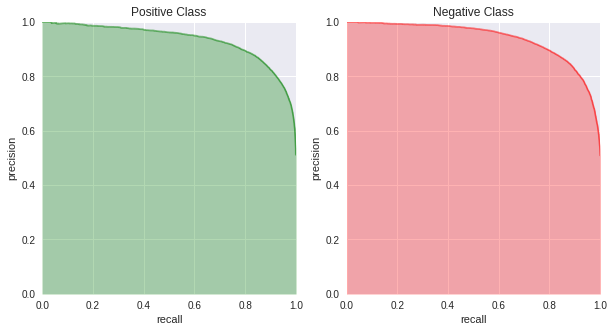

In [45]:
plt.figure(num=1,figsize=(10,5))
#Positive reviews
ax = plt.subplot(1,2,1) 
sns.lineplot(x='recall',y='precision',data=pos_pre_rec,ax=ax,color='green', alpha=0.5)
plt.fill_between(pos_pre_rec.recall.values, pos_pre_rec.precision.values, color='green', alpha=0.3)
plt.title('Positive Class')
plt.xlim(0,1)
plt.ylim(0,1)
#Negative reviews
ax = plt.subplot(1,2,2) 
sns.lineplot(x='recall',y='precision',data=neg_pre_rec,ax=ax,color='red', alpha=0.5)
plt.fill_between(neg_pre_rec.recall.values, neg_pre_rec.precision.values, color='red', alpha=0.3)
plt.title('Negative Class')
plt.xlim(0,1)
plt.ylim(0,1);


Let's now check how the average probability of being positive and the percentage of predicted positive reviews varies 
with the number of stars of the reviews

In [46]:
stars = np.unique(test_stars)
stars.sort()
my_df={'Stars': stars, 
       'Avg Prob':[test_probas[test_stars==i].mean() for i in stars],
      'Pos Revs': [(test_probas[test_stars==i]>=0.5).mean()*100 for i in stars]}

my_df = pd.DataFrame(my_df)
my_df

,Stars,Avg Prob,Pos Revs
0,1,0.127979,7.964954
1,2,0.166115,10.729800
2,3,0.227939,17.119244
3,4,0.293977,25.009488
4,7,0.714401,76.679671
5,8,0.793454,85.192982
6,9,0.823808,88.950512
7,10,0.844593,89.637928


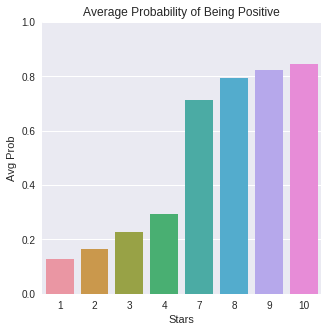

In [47]:
plt.figure(num=2,figsize=(5,5))
sns.barplot(x='Stars',y='Avg Prob',data=my_df)
plt.title('Average Probability of Being Positive')
plt.ylim(0,1);

In general, the higher the stars awarded to the review the higher the probability of it being positive based on our model (at least on average) 

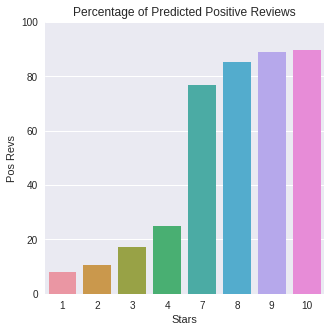

In [48]:
plt.figure(num=3,figsize=(5,5))
sns.barplot(x='Stars',y='Pos Revs',data=my_df)
plt.title('Percentage of Predicted Positive Reviews')
plt.ylim(0,100);

In general, the higher the stars awarded to a given review, the easier for the model to identify it as positive.

### Inference on a test review

Let's write a predict function which will output if a provided review is positive or negative, as well as the probability


In [49]:
def predict(net, test_review, sequence_length=200, alignment='right'):
    ''' Prints out whether a give review is predicted to be 
        positive or negative in sentiment, using a trained model.
        
        params:
        net - A trained net 
        test_review - a review made of normal text and punctuation
        sequence_length - the padded length of a review
        '''
    #Default sequence aligment: the one provided by the model if any
    if sequence_length is None:
        sequence_length = net.seq_length
    #get lower case review
    test_review = test_review.lower()
    #remove some contractions
    test_review = remove_contractions(test_review)
    #remove punctuation
    test_review = ''.join([c for c in test_review if c not in punctuation])
    #split in words
    test_review = test_review.split()
    #Encode the words
    unk = net.word_to_int.get('<unk>')
    test_review = [[net.word_to_int.get(word,unk) for word in test_review[:sequence_length]]]
    #Padding
    test_review = pad_features(test_review, sequence_length, alignment=alignment)
    #Convert into pytorch tensor
    test_review = torch.from_numpy(test_review).type(torch.LongTensor).to(device)
    
    net.to(device)
    net.eval()
    pred = net(test_review).squeeze().item()
    if pred >= 0.5:
        pred = ('Positive', pred)
    else:
        pred = ('Negative', pred)
    return pred
    
        

In [50]:
# negative test review
test_review_neg = 'The worst movie I have seen; acting was terrible and I want my money back. This movie had bad acting and the dialogue was slow.'


In [51]:
# positive test review
test_review_pos = 'This movie had the best acting and the dialogue was so good. I loved it.'


In [52]:
# call function for positive and negative reviews
print(predict(net, test_review_neg, alignment='center'))
print(predict(net, test_review_pos, alignment='center'))

('Negative', 0.004679705481976271)
('Positive', 0.8827115893363953)


---
## Dependency of the Predictions on the Length of the Sequence

We have implemented our CNN in such a way that we only send to the classifier (fully connected network) a fixed number of values per filter. Then we can actually use sequences of diffetrent lengths without modifying the net. Out of curiosity, we will test how the size of the sequences modifies the predictions for the longest misclassified review and for the longest review correctly classified.

Let's start with the corretly classified review

In [53]:
test_goodies_mask = ((test_y) == (test_probas>0.5))
test_goodies_idx = np.arange(0,len(test_y),dtype=np.int)[test_goodies_mask]
test_goodies_lens = np.array([len(test_reviews_int[idx]) for idx in test_goodies_idx])
argmax = test_goodies_lens.argmax()
my_idx = test_goodies_idx[argmax]
print(f"Length of the review: {len(test_reviews_int[my_idx])}")
print(f"Stars: {test_stars[my_idx]}\tLabel: {test_y[my_idx]}\tPrediction:{test_probas[my_idx]:.4f}")

Length of the review: 2328
Stars: 10	Label: 1	Prediction:0.5637


In [54]:
print('The review:')
with open(test_pos_dir+test_pos_rev_files[my_idx], 'r',encoding="utf8") as f:
    my_review=f.read()
    print(my_review)

The review:
There's a sign on The Lost Highway that says:<br /><br />*MAJOR SPOILERS AHEAD*<br /><br />(but you already knew that, didn't you?)<br /><br />Since there's a great deal of people that apparently did not get the point of this movie, I'd like to contribute my interpretation of why the plot makes perfect sense. As others have pointed out, one single viewing of this movie is not sufficient. If you have the DVD of MD, you can "cheat" by looking at David Lynch's "Top 10 Hints to Unlocking MD" (but only upon second or third viewing, please.) ;)<br /><br />First of all, Mulholland Drive is downright brilliant. A masterpiece. This is the kind of movie that refuse to leave your head. Not often are the comments on the DVDs very accurate, but Vogue's "It gets inside your head and stays there" really hit the mark.<br /><br />David Lynch deserves praise for creating a movie that not only has a beautifully stylish look to it - cinematography-wise, has great acting (esp. Naomi Watts), a h

In [55]:
for sl in range(200,len(test_reviews_int[my_idx]),50):
    print(f"Length:{sl}\t{predict(net, my_review, sequence_length=sl, alignment='center')}")

Length:200	('Positive', 0.950771152973175)
Length:250	('Positive', 0.93666011095047)
Length:300	('Positive', 0.5891203284263611)
Length:350	('Positive', 0.5637445449829102)
Length:400	('Positive', 0.5630823969841003)
Length:450	('Positive', 0.555988073348999)
Length:500	('Positive', 0.5753641724586487)
Length:550	('Positive', 0.5977988243103027)
Length:600	('Positive', 0.5717465877532959)
Length:650	('Positive', 0.5618473291397095)
Length:700	('Positive', 0.5610382556915283)
Length:750	('Positive', 0.5610247254371643)
Length:800	('Positive', 0.5365739464759827)
Length:850	('Positive', 0.5361559987068176)
Length:900	('Positive', 0.5357306599617004)
Length:950	('Positive', 0.5361732244491577)
Length:1000	('Positive', 0.5341826677322388)
Length:1050	('Positive', 0.5341410636901855)
Length:1100	('Positive', 0.5341410636901855)
Length:1150	('Positive', 0.5341455936431885)
Length:1200	('Positive', 0.5343227386474609)
Length:1250	('Positive', 0.5345247983932495)
Length:1300	('Positive', 0.534

Independently of the size, the network predicts a possitive sentiment (the correct result). On the other hand the probability varies widly (0.53-0.95) and the best results are obtained if the sequence length is smaller that 300 words. For sequence lengths larger than 750, the probability remains almost constant at 0.53.

Let's see how it affects the misclassified review

In [56]:
test_error_mask = ((test_y) == (test_probas<0.5))
test_erorr_idx = np.arange(0,len(test_y),dtype=np.int)[test_error_mask]
test_error_lens = np.array([len(test_reviews_int[idx]) for idx in test_erorr_idx])
argmax = test_error_lens.argmax()
my_idx = test_erorr_idx[argmax]
print(f"Length of the review: {len(test_reviews_int[my_idx])}")
print(f"Stars: {test_stars[my_idx]}\tLabel: {test_y[my_idx]}\tPrediction:{test_probas[my_idx]:.4f}")

Length of the review: 2154
Stars: 10	Label: 1	Prediction:0.1349


In [57]:
print('The review:')
with open(test_pos_dir+test_pos_rev_files[my_idx], 'r',encoding="utf8") as f:
    my_review=f.read()
    print(my_review)

The review:
Back in the mid/late 80s, an OAV anime by title of "Bubblegum Crisis" (which I think is a military slang term for when technical equipment goes haywire) made its debut on video, taking inspiration from "Blade Runner", "The Terminator" and maybe even "Robocop", with a little dash of Batman/Bruce Wayne - Iron Man/Tony Stark and Charlie's Angel's girl power thrown in for good measure. 8 episodes long, the overall story was that in 21st century Tokyo, Japan, year 2032-2033, living machines called Boomers were doing manual labor and sometimes cause problems. A special, SWAT like branch of law enforcers, the Advanced Police (AD Police for short) were formed to handle the boomers, but were mostly ineffective, prompting millionaire scientist Sylia Stingray, the daughter of the scientist who made the boomers, to create four powered combat armor (hard suits) to be worn by women to fight the boomers and fight the evil corporation that produced the boomers, GENOM. That group becomes kn

In [58]:
for sl in range(200,len(test_reviews_int[my_idx]),50):
    print(f"Length:{sl}\t{predict(net, my_review, sequence_length=sl, alignment='center')}")

Length:200	('Negative', 0.27168452739715576)
Length:250	('Negative', 0.2719045877456665)
Length:300	('Negative', 0.2028893679380417)
Length:350	('Negative', 0.13491219282150269)
Length:400	('Negative', 0.08929675072431564)
Length:450	('Negative', 0.23724815249443054)
Length:500	('Negative', 0.22157463431358337)
Length:550	('Negative', 0.21964150667190552)
Length:600	('Negative', 0.24306334555149078)
Length:650	('Negative', 0.476505309343338)
Length:700	('Positive', 0.5316502451896667)
Length:750	('Positive', 0.5303851962089539)
Length:800	('Positive', 0.5303165912628174)
Length:850	('Positive', 0.5303165912628174)
Length:900	('Positive', 0.5304065942764282)
Length:950	('Positive', 0.5302416682243347)
Length:1000	('Positive', 0.5302221775054932)
Length:1050	('Positive', 0.5301390886306763)
Length:1100	('Positive', 0.6024633646011353)
Length:1150	('Positive', 0.5627065300941467)
Length:1200	('Positive', 0.5617643594741821)
Length:1250	('Positive', 0.5617643594741821)
Length:1300	('Positi

Once again the probabilities strongly depend on the sequence length (0.09-0.57). Interestingly, the review is rightly classify as positive for sequence lengths of at least 700 words.